In [1]:
!pip install pandas-datareader yfinance

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf

In [25]:
# ハイパーパラメータ
BATCH_SIZE = 126
HIDDEN_SIZE = 256
N_EPOCH = 100

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
yf.pdr_override()
y_symbols = ['^GSPC']
startdate = datetime(1980,1,1)
enddate = datetime(2023,5,31)
df = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)
df.reset_index(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-02,0.0,108.430000,105.290001,105.760002,105.760002,40610000
1,1980-01-03,0.0,106.080002,103.260002,105.220001,105.220001,50480000
2,1980-01-04,0.0,107.080002,105.089996,106.519997,106.519997,39130000
3,1980-01-07,0.0,107.800003,105.800003,106.809998,106.809998,44500000
4,1980-01-08,0.0,109.290001,106.290001,108.949997,108.949997,53390000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10945 entries, 0 to 10944
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10945 non-null  datetime64[ns]
 1   Open       10945 non-null  float64       
 2   High       10945 non-null  float64       
 3   Low        10945 non-null  float64       
 4   Close      10945 non-null  float64       
 5   Adj Close  10945 non-null  float64       
 6   Volume     10945 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 598.7 KB


In [6]:
df = df.drop(['Open', 'Low', 'High', 'Volume', 'Adj Close'], axis=1)
df['25MA'] = df['Close'].rolling(window=25, min_periods=0).mean()
df['75MA'] = df['Close'].rolling(window=75, min_periods=0).mean()
df['200MA'] = df['Close'].rolling(window=200, min_periods=0).mean()
df.head()

,Date,Close,25MA,75MA,200MA
0,1980-01-02,105.760002,105.760002,105.760002,105.760002
1,1980-01-03,105.220001,105.490002,105.490002,105.490002
2,1980-01-04,106.519997,105.833333,105.833333,105.833333
3,1980-01-07,106.809998,106.077499,106.077499,106.077499
4,1980-01-08,108.949997,106.651999,106.651999,106.651999


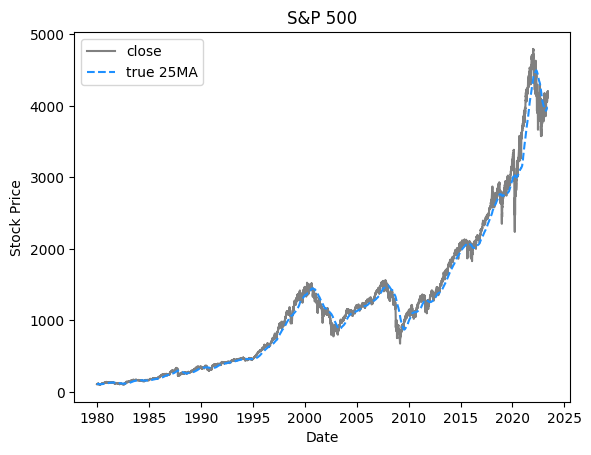

In [7]:
def plt_chart(date, close, true_ma, pred_ma = None):
    plt.figure()
    plt.title('S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.plot(date, close, color='gray', linestyle='-', label='close')
    plt.plot(date, true_ma, color='dodgerblue', linestyle='--', label='true 25MA')
    if pred_ma is not None:
        plt.plot(date, pred_ma, color='red', linestyle=':', label='predicted 25MA')
    plt.legend()
    plt.show()
plt_chart(df['Date'], df['Close'], df['200MA'])

In [8]:
# 標準化
ma = df['25MA'].values.reshape(-1, 1)
scaler = StandardScaler()
ma_std = scaler.fit_transform(ma)
print("ma: {}".format(ma))
print("ma_std: {}".format(ma_std))

ma: [[ 105.76000214]
 [ 105.49000168]
 [ 105.83333333]
 ...
 [4133.12080078]
 [4135.99800781]
 [4138.73720703]]
ma_std: [[-1.0515125 ]
 [-1.05176711]
 [-1.05144335]
 ...
 [ 2.74627787]
 [ 2.74899107]
 [ 2.75157412]]


In [9]:
data = []  # 入力データ(過去25日分の移動平均)
label = []  # 出力データ(1日後の移動平均)
for i in range(len(ma_std) - 25):
    data.append(ma_std[i:i + 25])
    label.append(ma_std[i + 25])
data = np.array(data)
label = np.array(label)
print("data size: {}".format(data.shape))
print("label size: {}".format(label.shape))

data size: (10920, 25, 1)
label size: (10920, 1)


In [10]:
# 訓練データとテストデータのサイズを決定
test_len = int(252)  # 1年分(252日分)
train_len = int(data.shape[0] - test_len)
# 訓練データの準備
train_data = data[:train_len]
train_label = label[:train_len]
# テストデータの準備
test_data = data[train_len:]
test_label = label[train_len:]
# データの形状を確認
print("train_data size: {}".format(train_data.shape))
print("test_data size: {}".format(test_data.shape))
print("train_label size: {}".format(train_label.shape))
print("test_label size: {}".format(test_label.shape))

train_data size: (10668, 25, 1)
test_data size: (252, 25, 1)
train_label size: (10668, 1)
test_label size: (252, 1)


In [26]:
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# ミニバッチサイズを指定したデータローダーを作成
train_batch = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_batch = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

data, label = next(iter(train_batch))
print("batch data size: {}".format(data.size()))
print("batch label size: {}".format(label.size()))

batch data size: torch.Size([126, 25, 1])
batch label size: torch.Size([126, 1])


In [35]:
class RNN(nn.Module):
     def __init__(self, hidden_dim):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(1, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        
     def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        output = self.linear(output[:, -1, :])
        return output

model = RNN(
    hidden_dim=HIDDEN_SIZE
)
model = model.to(device)
model

RNN(
  (rnn): LSTM(1, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [34]:
criterion = nn.MSELoss()  # 損失関数（平均二乗誤差: MSE）
optimizer = optim.Adam(model.parameters())

train_losses = [0] * N_EPOCH
test_losses = [0] * N_EPOCH
test_maes = [0] * N_EPOCH
for epoch in range(N_EPOCH):
    model.train()
    train_total = 0
    train_loss = 0
    for data, labels in train_batch:
        data = data.to(device)
        labels = labels.to(device)
        # パラメータの勾配をリセット
        optimizer.zero_grad()
        predictions = model(data)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_total += 1
        train_loss += loss.item()

    model.eval()
    test_total = 0
    test_loss = 0
    pred_ma = []
    true_ma = []
    with torch.no_grad():
        for data, labels in test_batch:
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data)
            loss = criterion(predictions, labels)
            pred_ma[len(pred_ma):len(pred_ma)] = predictions.tolist()
            true_ma[len(true_ma):len(true_ma)] = labels.tolist()
            test_total += 1
            test_loss += loss.item()

    # LossとAccuracyを表示
    train_losses[epoch] = train_loss / train_total
    test_losses[epoch] = test_loss / test_total
    pred_ma = scaler.inverse_transform(pred_ma)
    true_ma = scaler.inverse_transform(true_ma)
    test_maes[epoch] = mean_absolute_error(true_ma, pred_ma)
    print(f'Epoch: {epoch+1}, Train Loss: {train_losses[epoch]:.10f}, Test Loss: {test_losses[epoch]:.10f}, MAE: {test_maes[epoch]}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (126x512 and 256x1)

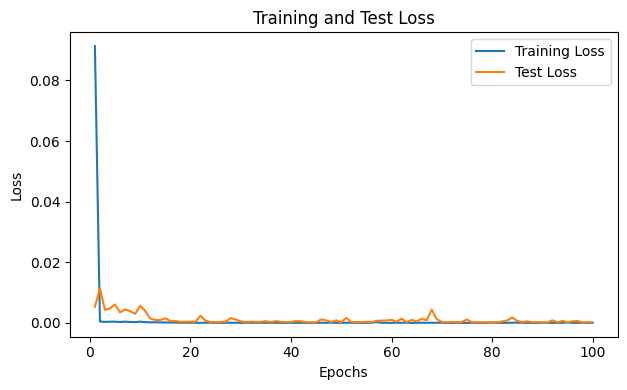

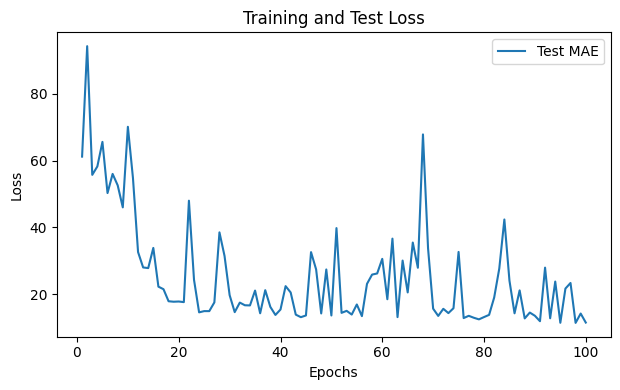

In [29]:
def plot_learning_curves(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(train_losses, test_losses)

def plot_mae_curves(test_maes):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, test_maes, label='Test MAE')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_mae_curves(test_maes)

MAE: 11.512


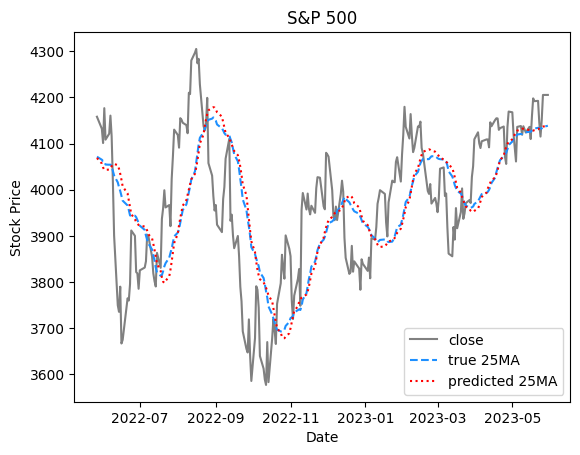

In [30]:
model.eval()
with torch.no_grad():
    pred_ma = []
    true_ma = []
    for data, label in test_batch:
        data = data.to(device)
        label = label.to(device)
        y_pred = model(data)
        pred_ma[len(pred_ma):len(pred_ma)] = y_pred.tolist()
        true_ma[len(true_ma):len(true_ma)] = label.tolist()

# 標準化を解除して元の株価に変換
pred_ma = scaler.inverse_transform(pred_ma)
true_ma = scaler.inverse_transform(true_ma)

# 平均絶対誤差を計算
mae = mean_absolute_error(true_ma, pred_ma)
print("MAE: {:.3f}".format(mae))
# 終値と25日移動平均を図示
date = df['Date'][-1*test_len:]
test_close = df['Close'][-1*test_len:].values.reshape(-1)  # テストデータの終値

plt_chart(date, test_close, true_ma, pred_ma)